<div id="container" style="position:relative;">
<div style="float:left"><h1> Time Series Analysis </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

A time series is a sequence of measurements from a system that varies in time. More formally, _a time series or stochastic process_ is a sequence of random variables indexed by time (“stochastic” is a synonym for random). When we collect or observe a time series data set, we obtain one possible outcome, or realization, of the stochastic process. The main goal of time series analysis is to 
- understand the patterns and relationships in the observed data,
- model the processes that gave rise to the observations, and
- forecast future behavior of the series using past observations.

Time series analysis is unique in that we often don't have information about the features which can influence a dependent variable of interest. We only have measurements of our variable; examples can include daily precipitation, stock market prices, number of accidents at an intersection but more complex data streams as well such as speech or video signals. 

In [57]:
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm



## Case Study: Air Travel Revenue Forecasting

Our exploration of time series analysis will be through a case study: we are tasked with understanding the demand and revenue from air travel in the US based on historical data. Specifically, we will look at daily records starting at 1979 up until 2002, right after a major disruption to the industry. Our employers are interested in the following questions:

1. What changes can we observe year-over-year?
2. How does time-of-year affect air travel revenue?
3. Given that the level of travel returns to normal after 2001, how much growth and monthly revenue can we expect in the following years?

Our plan is to address the first two questions mostly through EDA and, to address the third question, construct a model for monthly revenue that can be used for forecasting.

We are provided with the following data set ([original source](https://www.bts.gov/archive/publications/transportation_indicators/october_2002/Special/A_Time_Series_Analysis_of_Domestic_Air_Seat_and_Passenger_Miles)):

In [58]:
metro_df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
metro_df.info()
print(metro_df.head())

# write a function that returns august 9 to august 21st 2016
metro_df['date_time'] = pd.to_datetime(metro_df['date_time'])

metro_df['date_month'] = metro_df['date_time'].dt.month
metro_df['date_year'] = metro_df['date_time'].dt.year


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB
  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0

In [59]:

new_df = metro_df[metro_df['date_year'] == 2016][metro_df['date_month'] == 8]
hourly = new_df.copy()

hourly['traffic_volume'] = hourly.traffic_volume.rolling(7).mean(2)


C:\Users\Samsickle\AppData\Local\Temp\ipykernel_22524\1898006762.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [60]:
px.line(new_df, x='date_time', y='traffic_volume')


In [61]:
px.line(hourly, x='date_time', y='traffic_volume')



In [62]:
air_traffic = pd.read_csv("data/daily_air_df_missing.csv")
air_traffic.head()

,Date,Revenue Passenger Miles,Available Seat Miles,Unused Seat Miles
0,1979-01-01,0.533548,0.885712,0.396440
1,1979-01-02,0.525592,0.877129,0.382670
2,1979-01-03,0.492732,0.824325,0.334139
3,1979-01-04,0.520035,0.897259,0.370691
4,1979-01-05,0.527121,0.909226,0.367735


The data spans around 20 years and we have three features recorded:
- **Available seat-miles** for an individual flight are the number of seats multiplied by the distance traveled; this measure can represent overall capacity. 
- **Revenue passenger-miles** are a measure of the volume of air passenger transportation; a revenue passenger-mile is equal to one paying passenger carried one mile. 
- **Unused seat-miles** are the difference between available seat-miles and revenue passenger miles; the unused seat-miles are used as a measure of airline capacity utilization.

In [63]:
air_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8320 entries, 0 to 8319
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     8320 non-null   object 
 1   Revenue Passenger Miles  8149 non-null   float64
 2   Available Seat Miles     8149 non-null   float64
 3   Unused Seat Miles        8149 non-null   float64
dtypes: float64(3), object(1)
memory usage: 260.1+ KB


We fix the `Date` column first by converting it to date type and setting it as index:

In [64]:
air_traffic["Date"] = pd.to_datetime(air_traffic["Date"])
air_traffic = air_traffic.set_index("Date")

air_traffic.head()

,Revenue Passenger Miles,Available Seat Miles,Unused Seat Miles
Date,,,
1979-01-01,0.533548,0.885712,0.396440
1979-01-02,0.525592,0.877129,0.382670
1979-01-03,0.492732,0.824325,0.334139
1979-01-04,0.520035,0.897259,0.370691
1979-01-05,0.527121,0.909226,0.367735


Using `.info()` now reveals the time span of our data:

In [65]:
air_traffic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8320 entries, 1979-01-01 to 2002-04-01
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Revenue Passenger Miles  8149 non-null   float64
 1   Available Seat Miles     8149 non-null   float64
 2   Unused Seat Miles        8149 non-null   float64
dtypes: float64(3)
memory usage: 260.0 KB


We are ready to take our first look at the data using `plotly`:

In [66]:
# add lines for each column
fig = px.line(air_traffic, x=air_traffic.index, y=air_traffic.columns,)

# axis labels and title
fig.update_layout(
    yaxis_title="Passenger-miles (billions)", 
    legend_title="", 
    title="Daily air travel from 1979 to 2002"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

Note: you can explore `plotly`'s time series functionalities [in their documentation](https://plotly.com/python/time-series/) further.

#### Exercise 1.

Looking at the plot above, discuss the following questions together as a class:
1. Which time series patterns can you point out in Revenue Passenger Miles?
2. Can you explain the sudden disruption to air travel in 2001?

---

## Time Series Data Cleaning & EDA

Our first goal is to better understand the data and to deal with possible missing values and anomalies (such as missing dates).

In [67]:
air_traffic.shape

(8320, 3)

In [68]:
first_day = air_traffic.index.min()
last_day = air_traffic.index.max()

# pandas `Timestamp` objects
first_day, last_day

(Timestamp('1979-01-01 00:00:00'), Timestamp('2002-04-01 00:00:00'))

The `pd.Timestamp` objects allow us to extract various datetime features or do arithmetic with dates:

In [69]:
first_day.year, first_day.month, first_day.day

(1979, 1, 1)

The result of subtracting two dates is a `pd.Timedelta` object:

In [70]:
last_day - first_day

Timedelta('8491 days 00:00:00')

We can add durations using `pd.DateOffset`:

In [71]:
first_day + pd.DateOffset(years=1, months=3)

Timestamp('1980-04-01 00:00:00')

### Missing values and dates 

First, we will check if there are any dates missing from our index of if we have a record for each day between the first and last row. We can construct the full date range between our first and last observation date and see the difference with our index:

In [72]:
full_range = pd.date_range(start=first_day, end=last_day, freq="D")

full_range.difference(air_traffic.index)

DatetimeIndex(['1979-05-13', '1980-01-19', '1980-02-18', '1980-03-03',
               '1980-03-08', '1980-04-21', '1980-06-18', '1980-08-31',
               '1980-11-29', '1981-03-07',
               ...
               '2001-03-22', '2001-03-26', '2001-04-09', '2001-06-23',
               '2001-07-01', '2001-07-14', '2001-09-26', '2001-12-08',
               '2002-03-03', '2002-03-27'],
              dtype='datetime64[ns]', length=172, freq=None)

There are 172 days over 23 years that are missing from our data. We will add these dates to our index but first let's see if we have missing column values:

In [73]:
air_traffic.isna().sum()

Revenue Passenger Miles    171
Available Seat Miles       171
Unused Seat Miles          171
dtype: int64

Let's look at all the rows which contain any null values:

In [74]:
air_traffic[air_traffic.isna().any(axis=1)]

,Revenue Passenger Miles,Available Seat Miles,Unused Seat Miles
Date,,,
1979-02-18,NaN,NaN,NaN
1979-03-22,NaN,NaN,NaN
1979-03-27,NaN,NaN,NaN
1979-06-30,NaN,NaN,NaN
1979-08-03,NaN,NaN,NaN
...,...,...,...
2001-07-09,NaN,NaN,NaN
2001-09-11,NaN,NaN,NaN
2001-09-18,NaN,NaN,NaN


This confirms that these 171 values are missing from exactly the same rows in all three columns.

Now, to add the missing dates, we can either use the `reindex` method with our full date range, or simply call the `asfreq` method:

In [75]:
air_traffic_clean = air_traffic.reindex(full_range)

# the same without defining the range by hand

# air_traffic_clean = air_traffic.asfreq("D")

We are expecting now 172+171=343 null values in each column:

In [76]:
air_traffic_clean.isna().sum()



Revenue Passenger Miles    343
Available Seat Miles       343
Unused Seat Miles          343
dtype: int64

Next, to impute the missing values we have three common options:
- `forward filling`: the missing value is filled by the last valid column value,
- `backward filling`: the missing value is filled by the next following valid observation,
- `interpolation`: use previous and following value(s) to interpolate the missing one (e.g., using the mean or some linear combination like a rolling average).

The diagram below demonstrates the three approaches:

<center>
<img src="https://drive.google.com/uc?export=view&id=1XPBjnEhEHPMWUDukNSb3QAqjPV2wsbLB" width = 700/>
</center>


#### Exercise 2

Our goal is to better understand the distribution of dates for the missing values and then fill these appropriately. 
1. Create a chart that shows the null values for our data frame (tip: visualize the result of applying the `.isna()` method with a seaborn heatmap). We could use this as a quick diagnostic tool to see if there are long runs of adjacent missing values or any other apparent patterns.
2. Use the `fillna()` method with forward filling to impute the missing values.

---

([], [])

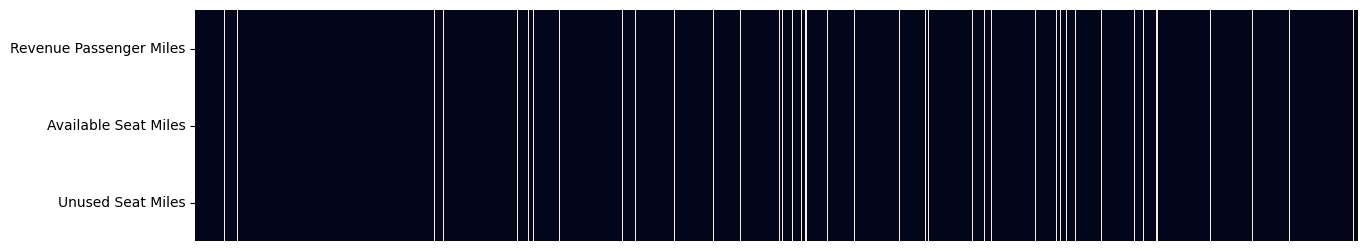

In [77]:
plt.figure(figsize=(15, 3))

sns.heatmap(air_traffic_clean.isna().T, cbar=False)

plt.xticks([])

Ignore the time series aspect of our data for a moment and let's look at the distribution of our features:


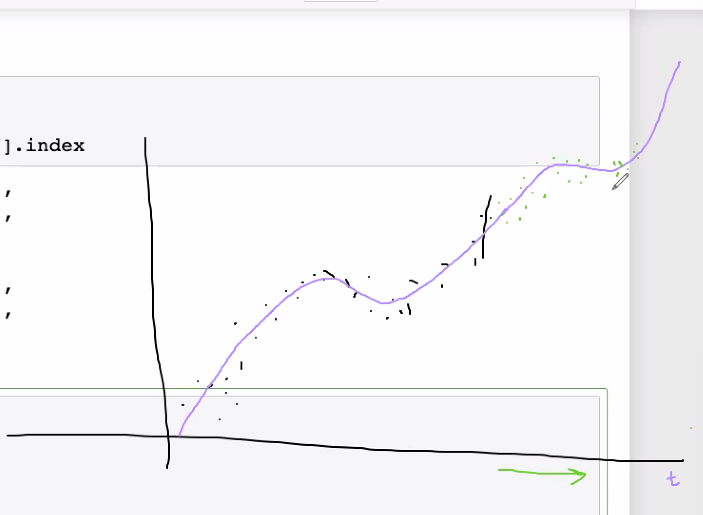

### Exploring time-of-year

Since we are focusing on higher level trends, we will _resample_ our daily records to monthly data, summing up the day-by-day values to get a single monthly total. This can be achieved by using a `groupby` function however, for time series data, it is simpler to apply the dedicated `resample` method (see more information on the [available frequencies here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)):

In [78]:
# the "MS" option specifies Monthly frequency by Start day
air_traffic_monthly = air_traffic_clean.resample("MS").sum()

air_traffic_monthly.head() 

,Revenue Passenger Miles,Available Seat Miles,Unused Seat Miles
1979-01-01,16.225462,27.447213,11.492240
1979-02-01,15.032169,24.355012,9.609981
1979-03-01,18.185524,27.067285,8.494188
1979-04-01,17.095874,23.146433,6.191794
1979-05-01,16.066268,23.515405,7.509077


Just as `groupby`, the `resample` method can be combined with the usual aggregation functions such as `mean`, `sum` or `max`, or with a user-defined custom function through the `apply` interface.

In [79]:
fig = px.line(air_traffic_monthly, x=air_traffic_monthly.index, y="Revenue Passenger Miles",)
fig.update_layout(
    yaxis_title="Passenger-miles (billions)", 
    xaxis_title="Year",
    legend_title="", 
    title="Monthly air travel revenue from 1979 to 2002"
)
fig.show()

At this point, we will limit ourselves to the revenue column only and to years before the industry was disrupted.  We do this in order to analyze and make forecasts based on regular market behavior before the crash.

In [80]:
air_traffic_monthly = air_traffic_monthly.loc[air_traffic_monthly.index <= "2000-12-31", ["Revenue Passenger Miles"]]

air_traffic_monthly.tail()

,Revenue Passenger Miles
2000-08-01,46.425247
2000-09-01,36.871708
2000-10-01,40.020334
2000-11-01,37.672801
2000-12-01,38.019979


A common way to explore seasonality across multiple years is to use a _seasonal plot_ which is implemented in the `statsmodels` package.

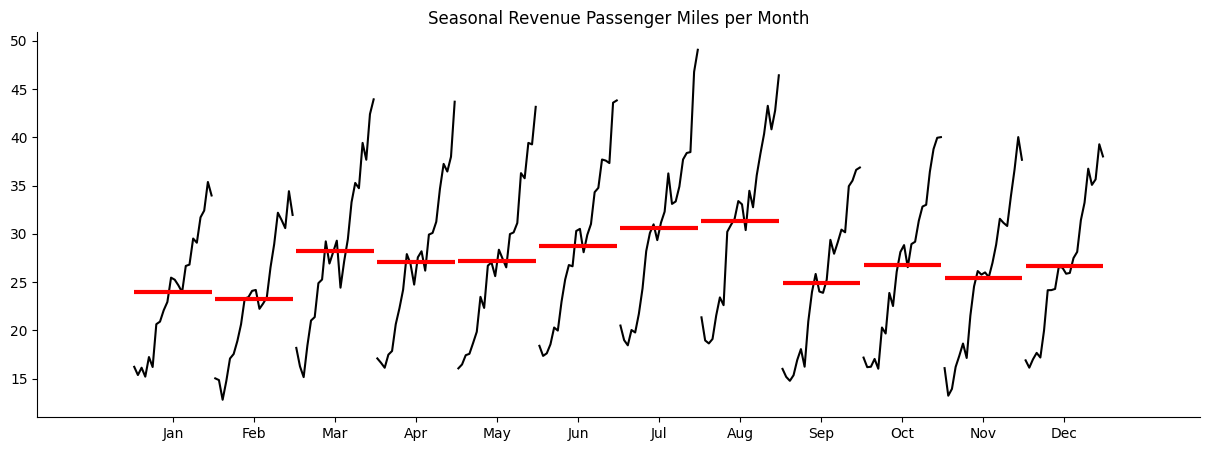

In [81]:
from statsmodels.graphics.tsaplots import month_plot

plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(air_traffic_monthly["Revenue Passenger Miles"], ax=plt.gca())

plt.title("Seasonal Revenue Passenger Miles per Month")
sns.despine()
plt.show()

The red bars show the average for the given month across all years, while each black line represent an individual month and the progression of values across the years. 

We can see the upward trend for each month and that on average, March and the late summer months perform better. Note that the lack of growth we saw in the late 1980s to early 1990s in the original run chart now shows up for each month individually as a short plateau/drop in the trend.

Now we can better understand the yearly periods that are clearly present in the data. We will look at the average revenue for each month and see how much it differs from the overall average.

In [82]:
# monthly average
monthly_mean = air_traffic_monthly.groupby(air_traffic_monthly.index.month_name()).mean()

# relative deviation from the overall mean
monthly_mean_diff = (monthly_mean - monthly_mean.mean())/monthly_mean

# month names in right order
month_names = pd.date_range(start='2000-01', freq='M', periods=12).month_name()

# reorder columns to follow the month order
monthly_mean_diff = monthly_mean_diff.loc[month_names, ]

monthly_mean_diff.T

,January,February,March,April,May,June,July,August,September,October,November,December
Revenue Passenger Miles,-0.126554,-0.163326,0.043766,0.000882,0.00678,0.060257,0.117646,0.138713,-0.086153,-0.009374,-0.06221,-0.012225


In [83]:
fig = px.bar(monthly_mean_diff)

fig.update_layout(
    yaxis_title="", 
    yaxis_tickformat = '%',
    xaxis_title="",
    title="Monthly deviation from mean revenue (%)",
    showlegend=False,
)
fig.show()

This is sorta a graph of the price inelasticity and fixed costs. airlines they should be pricing things perfectly and revenue neutral all the time - ideally but they can because of price controls and then their revenue

#### Exercise 3

Analyze the above bar chart and comment on how time-of-year affects air travel revenue. Can you explain the above and below average values? 

---


## Trend-Seasonal Decomposition 

A fundamental step in time series EDA is the trend-seasonal decomposition. Here, we extract three series from our original observation: 
- a trend component $T_t$ calculated using a moving average,
- a seasonal component $S_t$ which is the monthly/daily average of the de-trended series, and
- the residual $R_t$ that remains after subtracting the trend and seasonal component from the original series.

Adding up these three components will give back the original series:

$$y_t = T_t + S_t + R_t$$

There are different approaches for computing the trend and seasonal components, but the most standard method is implemented by the `seasonal_decompose` function from the time series analysis module of `statsmodels`. 

**Note**: In order to do this, we must have the date index so that the decomposition can infer the seasonality.


In [86]:
# decompose the time series
decomposition = tsa.seasonal_decompose(air_traffic_monthly, model='additive')



We get a special object as a result from which we can extract the three components: trend, seasonality and the residual.

In [87]:
type(decomposition)

statsmodels.tsa.seasonal.DecomposeResult

In [88]:
# add the decomposition data

air_traffic_monthly["Trend"] = decomposition.trend
air_traffic_monthly["Seasonal"] = decomposition.seasonal
air_traffic_monthly["Residual"] = decomposition.resid

air_traffic_monthly.head(10)

,Revenue Passenger Miles,Trend,Seasonal,Residual
1979-01-01,16.225462,NaN,-2.628551,NaN
1979-02-01,15.032169,NaN,-3.472706,NaN
1979-03-01,18.185524,NaN,1.557637,NaN
1979-04-01,17.095874,NaN,0.251766,NaN
1979-05-01,16.066268,NaN,0.380968,NaN
1979-06-01,18.402062,NaN,1.807402,NaN
1979-07-01,20.500506,17.384988,3.339259,-0.223741
1979-08-01,21.352318,17.342039,4.181276,-0.170997
1979-09-01,16.012606,17.254826,-2.255090,1.012870
1979-10-01,17.183491,17.156260,-0.525780,0.553011


The null values are due the fact that the trend component is calculated with a rolling average that is not defined at the beginning and end of the series.

In [89]:
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=air_traffic_monthly.index, y=air_traffic_monthly[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

We can make a few observations immediately:
- The trend is clearly upward, we can observe a long period where revenue plateaued 1987-1992 followed by a steady (linear) increase.
- The seasonal plot shows exactly what we observed using our bar plot for monthly differences.

- We can see that the residual still shows some seasonality. In general, it would be ideal to have that information captured by the seasonal component. We also see some  heteroscedasticity (changing variance) in the residual component. There are more advanced decomposition techniques that can account for such affects and extract a changing seasonal component.

---

## Forecasting

Based on the business context, we can focus on two alternative goals:
- **single-step (short-term) forecasts**, or
- **multi-step (long-term) forecasts**.

Since we are interested in how the air travel industry will recover from the 2001 shock, we are interested in the latter. Nonetheless, the focus here determines the way we fit and evaluate our models.

Many standard forecasting techniques work best on **stationary series**, one where the statistical properties of the series (such as mean and variance) don't change over time. Often, the residual after the decomposition is stationary however we did see some remaining seasonality for our time series.

We can address the latter issue by transforming the data (taking the logarithm or differencing) or by using more advanced decomposition techniques. Here, we show the effect of _seasonal differencing_ when we look to model the year-over-year change, instead of the original data:



<center>
<img src="https://drive.google.com/uc?export=view&id=1iFRz9HvD9sqNUKssmPGuwg8bGtXITvHp" width = 700/>
</center>


In [90]:
air_traffic_monthly["seasonal_difference"] = air_traffic_monthly["Revenue Passenger Miles"].diff(12)

In [91]:
air_traffic_monthly[["Revenue Passenger Miles", "seasonal_difference"]].head(16)

,Revenue Passenger Miles,seasonal_difference
1979-01-01,16.225462,NaN
1979-02-01,15.032169,NaN
1979-03-01,18.185524,NaN
1979-04-01,17.095874,NaN
1979-05-01,16.066268,NaN
1979-06-01,18.402062,NaN
1979-07-01,20.500506,NaN
1979-08-01,21.352318,NaN
1979-09-01,16.012606,NaN
1979-10-01,17.183491,NaN


The seasonal difference is visualized below:

In [92]:
fig = px.line(air_traffic_monthly, x=air_traffic_monthly.index, y="seasonal_difference")

fig.update_layout(
    yaxis_title="Difference (billions)", 
    xaxis_title="Date",
    title="Change in Revenue Passenger Miles over Prior Year"
)

fig.show()

Now, apart from the last year, it looks like we got stationary data:
- there is no clear trend in the new series, 
- the variance is relatively constant, and
- there is no seasonality but some multiyear cycles can be clearly spotted (a _cyclical pattern_ is characterized by rises and falls of uneven frequency). Note that this corresponds to the fast vs slow growth periods that we observed initially.

Our forecasting work will be based on predicting this differenced series instead of the original one.

**Note**: the original revenue series can be restored by using the first 12-month of revenue values and the seasonal differences by recursively adding the differences to the so-far restored values. We will do this once our forecast is ready.

### Splitting the Series for Evaluation

Our main goal is to explore models which can reliably forecast future travel revenue. To get a fair evaluation of such models, we will use some of the available data for fitting the model and some for evaluating our forecast. This ensures that calculated metrics reflect the models performance on unseen, future data.  

For our case:
- we will use observations up until January 1, 1997 as the _training set_ to infer the model parameters, and
- subsequent records as _test data_ for evaluation. 

In [93]:
# we drop the null values introduced at differencing
train = air_traffic_monthly.loc[air_traffic_monthly.index <= "1997-01-01", "seasonal_difference"].dropna()
test = air_traffic_monthly.loc[air_traffic_monthly.index > "1997-01-01", "seasonal_difference"]

In [94]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name="Test"))
fig.update_layout(
    yaxis_title="Difference (billions)", 
    xaxis_title="Date",
    title="Change in Revenue Passenger Miles over Prior Year"
)
fig.show()

### Baseline Forecasts and Evaluation

There are a number of ways to make simple forecasts which can act as baselines for putting more complex models in context:
- for short-term forecasts, we can predict the last available value (or a rolling average of previous values);
- for long-term forecasts of stationary series, we can predict the mean over the training set;
- for non-stationary data, we can model the trend (e.g., using linear regression) to forecast future trend and add the seasonality to obtain a forecast for the whole series.

Since our differenced series is stationary, we will use the mean (over the training set) as our baseline.

In [95]:
full_index = pd.concat([train, test]).index
base_line = np.full(full_index.shape, np.mean(train))

predictions = pd.Series(data=base_line, index=full_index)

In [96]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Mean Prediction"))

fig.update_layout(
    yaxis_title="Difference (billions)", 
    xaxis_title="Date",
    title="Change in Revenue Passenger Miles over Prior Year"
)
fig.show()

As with any regression model, we can use the mean absolute error or root mean squared error to evaluate our models (or apply other use-case specific measure of performance).

Both previous metrics are heavily influenced by the scale of the data. To put these numbers into perspective, we can look at what percentage (on average) our prediction is off by the original value. This metric is called the **_mean absolute percentage error_ (MAPE)** and going forward, we will use this metric to compare our models quantitatively.

In [97]:
def mean_absolute_percentage_error(true_values, predicted_values):
    """
    Calculate the mean absolute percentage error. 
    Find the prediction error and devide by the true value, then average.
    """
    
    error = true_values - predicted_values
    absolute_percentage_error = np.abs(error/true_values)
    mape = absolute_percentage_error.mean() * 100
    
    return mape

train_mape = mean_absolute_percentage_error(train, predictions[train.index])
test_mape = mean_absolute_percentage_error(test, predictions[test.index])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 211.19%
Test MAPE on the difference: 194.4%


### Autoregressive (AR) models

We specify an AR(1) process (read as autoregressive process of order 1) using the following equation:

$$ y_t = \beta_0 + \beta_1 y_{t-1} + \mathcal{N}(\mu,\,\sigma^2)  $$

The value at the next time stamp is modeled using a regression built on the previous time stamp values, plus a constant ($\beta_0$), and an error term. 

More generally, we can specify an AR(p) model as:

$$ y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} +...+ \beta_p y_{t-p} + \mathcal{N}(\mu,\,\sigma^2)  $$

This is very similar to a linear regression, except instead of using other attributes as our predictors, we use previous observations (the lags) of the same attribute.

When we make a forecast, we simply omit the error term and apply the formula to previous values:

$$ \hat{y}_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} +...+ \beta_p y_{t-p} $$



Given a time series, how do we find the best value of $p$ for our model? For this, we need to identify which lags are most strongly related to our series values.

### Autocorrelation and finding the order $p$ for AR models

_Autocorrelation plots_ help determine if the successive elements of a time series are positively correlated, negatively correlated, or independent of each other. Analysing the autocorrelations is a key step in finding the right parameters for (autoregressive) time series models.

When looking at correlation, we usually think of correlation between two variables like height and weight. With time series data, when looking at autocorrelation, we are calculating the correlation between the time series elements and the corresponding elements that were observed a certain time period earlier.  That time period is called the _lag_. 

As an example, the autocorrelation with lag 3 is the correlation between the revenue that were observed in a certain month and revenue prices that were recorded 3 month prior, as shown in the plot below. The plot below shows a clear positive correlation:

In [98]:
fig = px.scatter(
    x=air_traffic_monthly["Revenue Passenger Miles"], 
    y=air_traffic_monthly["Revenue Passenger Miles"].shift(3) # 3-month lagged observations
)
fig.update_layout(
    xaxis_title="Revenue on Current Month", 
    yaxis_title="Revenue 3-month Lagged"
)
fig.show()

We can look at autocorrelations generated with different lags which gives the so-called _autocorrelation function_. Looking at the original revenue first, the seasonality of the data is clearly visible in the autocorrelation plot as well:

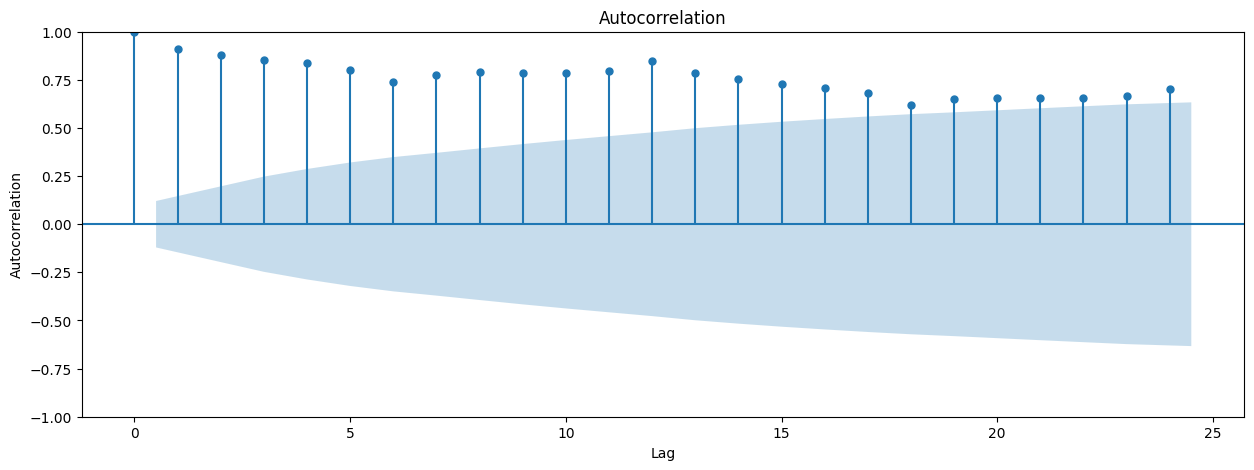

In [99]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_acf(air_traffic_monthly["Revenue Passenger Miles"], lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

However, this pattern is not present in the differenced data (the year-over-year change in revenue) anymore which also shows much weaker correlations across large lags:

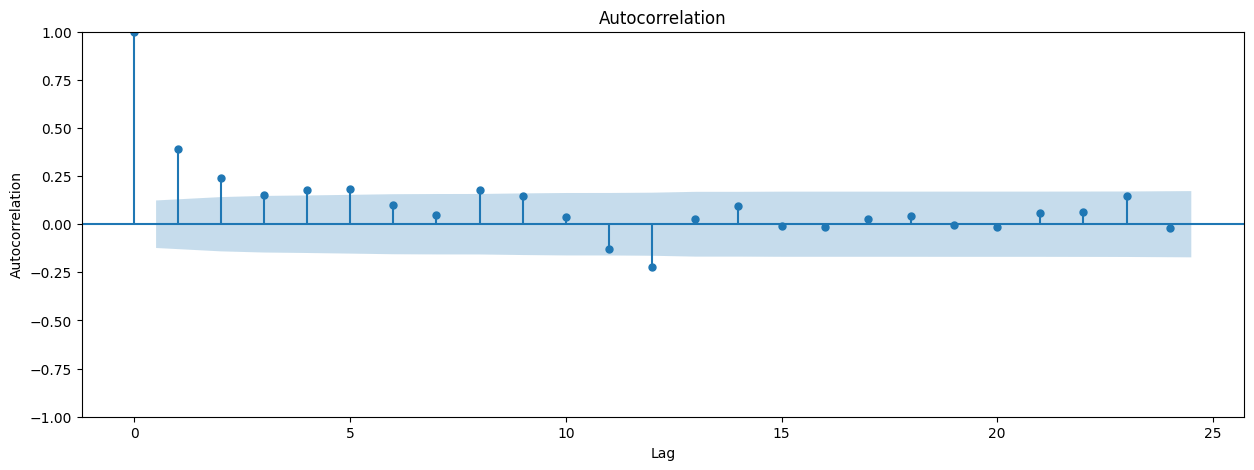

In [100]:
plt.figure(figsize=(15, 5))
plot_acf(air_traffic_monthly["seasonal_difference"].dropna(), lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The shaded area here corresponds to a 95% confidence interval for non-significant correlations.

The _partial autocorrelation_ is the autocorrelation after removing the effect of any correlations resulting from terms at shorter lags. We can get this plot using the _partial auto-correlation function_ (`pacf`) from `statsmodels`.

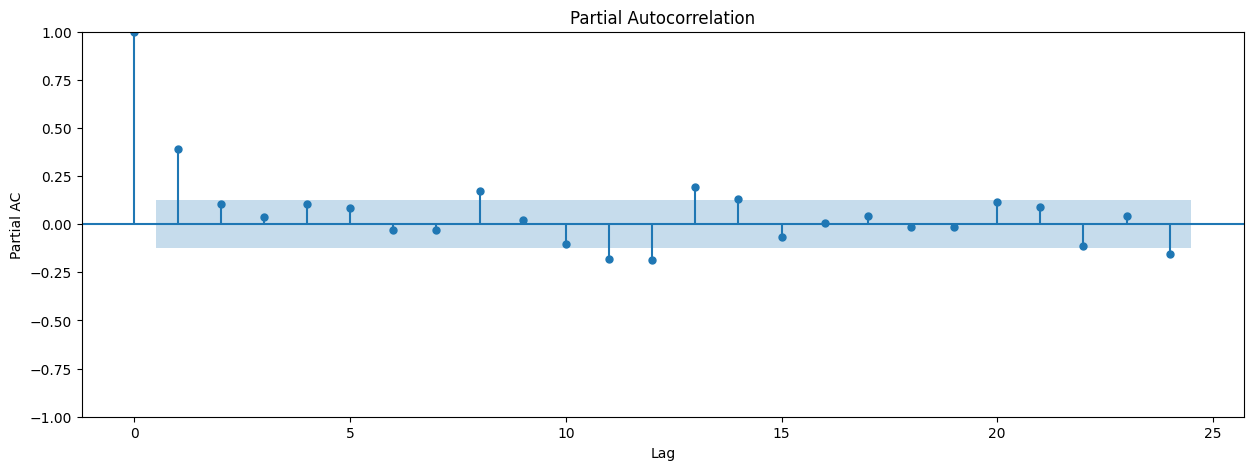

In [101]:
plt.figure(figsize=(15, 5))
plot_pacf(air_traffic_monthly["seasonal_difference"].dropna(), lags=24, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

As a rule-of-thumb for picking the right order parameter $p$, we should include all or most of the significant correlations in the PACF plot.

Looking at the above partial autocorrelation plot, we will set the number of lags used to be 2 although we see that the lag 12 and 13 are also significant - this is likely due to some remaining seasonality but let's ignore that for now.

#### Fitting an AR model with `statsmodels`

We can employ the `statsmodels` implementation of AR models by referring to a more general model called `SARIMAX` - the letter `AR` in the middle refer to the autoregressive component we aim to use. The `SARIMAX` implementation allows to fit much more complex models that could incorporate seasonality as well - we will touch on some of this complexity later.

The `SARIMAX` model takes three main _order_ parameters, the first of which specifies how many lags to use in the AR component.

In [102]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p_param = 2

model = SARIMAX(train, order=(p_param, 0, 0), trend="c")
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     seasonal_difference   No. Observations:                  205
Model:                SARIMAX(2, 0, 0)   Log Likelihood                -394.505
Date:                 Tue, 20 Jun 2023   AIC                            797.010
Time:                         08:37:51   BIC                            810.302
Sample:                     01-01-1980   HQIC                           802.386
                          - 01-01-1997                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4412      0.134      3.292      0.001       0.178       0.704
ar.L1          0.2951      0.064      4.577      0.000       0.169       0.421
ar.L2          0.2692      0.072      3.752      0.000       0.129       0.410
sigma2         2.7438      0.262     10.469      0.000       2.230       3.257
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.03
Prob(Q):                              0.94   Prob(JB):                         0.60
Heteroskedasticity (H):               1.65   Skew:                             0.11
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The full model can be written as:

$$y_t = 0.27 + 0.62\cdot y_{t-1} + 0.14\cdot y_{t-2}$$

where 
- $y_t$ is the current series value (differenced revenue), and
- $y_{t-1}$ and $y_{t-2}$ are the 1-and 2-month lagged series.

The coefficients can be interpreted similarly to linear regression: the positive lag-1 coefficient 0.3 tells us that a 1 unit increase in the month prior will drive up the current value by 0.3 (when all other lags remain fixed). 

Once the model was fitted, we can make predictions using either the `predict` or `forecast` method. We specify the start and end index for the `predict` method, where index 0 corresponds to the first element of our train data set. The predictions will apply the AR formula to the lagged train values as long as they are available. After the last training time step, the forecasted values will be reused in the formula to make the next prediction. 

In [103]:
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1)

In [104]:
predictions.head()

1980-01-01    1.012384
1980-02-01    0.260696
1980-03-01    0.159029
1980-04-01   -0.171758
1980-05-01   -0.207305
Freq: MS, Name: predicted_mean, dtype: float64

In [105]:
predictions.index.min()

Timestamp('1980-01-01 00:00:00', freq='MS')

In [106]:
predictions.index.max()

Timestamp('2000-12-01 00:00:00', freq='MS')

To demonstrate again how the formula is being applied, we can calculate the first forecast value by hand using the coefficients:

In [107]:
betas = model_fit.params
betas

intercept    0.441167
ar.L1        0.295077
ar.L2        0.269153
sigma2       2.743795
dtype: float64

In [108]:
# set the index for the prediction
current_idx = 2

print(f"Prediction by the model: {predictions[current_idx]}\n") 

print(f'Prediction by applying the formula: \
      {betas["intercept"] + betas["ar.L1"]*train[current_idx-1] + betas["ar.L2"]*train[current_idx-2]}') 

Prediction by the model: 0.15902862801983703

Prediction by applying the formula:       0.15902862801983708


The `forecast` method will forecast the time series values starting after the last observation in the training set.

In [109]:
train.index.max()

Timestamp('1997-01-01 00:00:00', freq='MS')

In [110]:
model_fit.forecast(steps=5)

1997-02-01    2.162075
1997-03-01    1.787041
1997-04-01    1.550410
1997-05-01    1.379644
1997-06-01    1.265565
Freq: MS, Name: predicted_mean, dtype: float64

We can verify that these are the same values that the `predict` method returns after the last train time step.

In [111]:
predictions[len(train): len(train)+5]

1997-02-01    2.162075
1997-03-01    1.787041
1997-04-01    1.550410
1997-05-01    1.379644
1997-06-01    1.265565
Freq: MS, Name: predicted_mean, dtype: float64

We see a similar picture, in the sense that our formula gives values that seem to follow the overall pattern in the data and captures the future trend better than the baseline prediction.

In [112]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Difference (billions)", 
    xaxis_title="Date",
    title="Change in Revenue Passenger Miles over Prior Year"
)
fig.show()

The forecast nicely captures the overall downward trend for in 1997 and 1998, however fails to account for the market picking up in the next cycle. We can also look at the errors again:

In [113]:
train_mape = mean_absolute_percentage_error(train, predictions[train.index])
test_mape = mean_absolute_percentage_error(test, predictions[test.index])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 263.69%
Test MAPE on the difference: 204.16%


This simple AR model gave a significantly better result on the training set however the test performance got worse. This is due to the AR model's poor performance over longer time spans as the predictions tend to converge.

**Note**: on the test set, we evaluated this baseline for forecasting multiple steps ahead, all the way from 1995 to 2000. In many cases, especially for short term forecasts, we build and evaluate models for 1-step forecasting which would involve refitting the model as soon as new data becomes available.

---


### Reconstructing the original series

We fitted the model on the seasonally differenced data, but how does our forecast translate to the original time series? In order to reconstruct the Revenue Passenger Miles from the seasonal difference, we start with the original 12 values and always looking back 12 months, we add the difference to get the next restored value.

<center>
<img src="https://drive.google.com/uc?export=view&id=1iEuzqm0y3nJz-ECjhVr_W2lHmLYMVEcr" width = 700/>
</center>


Let's write the code that achieves this:

In [114]:
# we slice out the first 12 month and the rest of the dates
first_year_indices = air_traffic_monthly.index[:12]
remaining_indices = air_traffic_monthly.index[12:]

# create an empty restored column
air_traffic_monthly["restored"] = np.nan

# fill in the first 12 original values into the empty restored column
air_traffic_monthly.loc[first_year_indices, "restored"] = \
    air_traffic_monthly.loc[first_year_indices, "Revenue Passenger Miles"]

# use the current difference value and 12-month lagged restored value to get the next restored value
for current_date in remaining_indices:
    current_value = air_traffic_monthly.loc[current_date, "seasonal_difference"]
    year_before_restored = air_traffic_monthly.loc[current_date - pd.DateOffset(months=12), "restored"]
    
    air_traffic_monthly.loc[current_date, "restored"] = year_before_restored + current_value

# check agreement everywhere (rounding errors can come up so check closeness rather than strict equality)
np.allclose(air_traffic_monthly["Revenue Passenger Miles"], air_traffic_monthly["restored"])

True

We can do the same for the AR prediction starting at the test set. First, we create a column that holds our differenced values based on the AR model:

In [115]:
# use the original train diff values and predicted test values
air_traffic_monthly.loc[train.index, "AR_difference"] = air_traffic_monthly.loc[train.index, "seasonal_difference"]
air_traffic_monthly.loc[test.index, "AR_difference"] = predictions[test.index]
air_traffic_monthly.head()

,Revenue Passenger Miles,Trend,Seasonal,Residual,seasonal_difference,restored,AR_difference
1979-01-01,16.225462,NaN,-2.628551,NaN,NaN,16.225462,NaN
1979-02-01,15.032169,NaN,-3.472706,NaN,NaN,15.032169,NaN
1979-03-01,18.185524,NaN,1.557637,NaN,NaN,18.185524,NaN
1979-04-01,17.095874,NaN,0.251766,NaN,NaN,17.095874,NaN
1979-05-01,16.066268,NaN,0.380968,NaN,NaN,16.066268,NaN


Then we repeat the same process that we tested for the original values:

In [116]:
# empty restored column
air_traffic_monthly["AR_restored"] = np.nan

# fill in the first 12 original values
air_traffic_monthly.loc[first_year_indices, "AR_restored"] = \
    air_traffic_monthly.loc[first_year_indices, "Revenue Passenger Miles"]


# use the current difference and 12-month lagged restored value to get the next restored
for current_date in remaining_indices:
    current_value = air_traffic_monthly.loc[current_date, "AR_difference"]
    year_before_restored = air_traffic_monthly.loc[current_date - pd.DateOffset(months=12), "AR_restored"]
    
    air_traffic_monthly.loc[current_date, "AR_restored"] = year_before_restored + current_value


Unsurprisingly, the first few rows match since we used the original seasonal difference values for the indices corresponding to the training portion of the data.

In [117]:
air_traffic_monthly.head(14)

,Revenue Passenger Miles,Trend,Seasonal,Residual,seasonal_difference,restored,AR_difference,AR_restored
1979-01-01,16.225462,NaN,-2.628551,NaN,NaN,16.225462,NaN,16.225462
1979-02-01,15.032169,NaN,-3.472706,NaN,NaN,15.032169,NaN,15.032169
1979-03-01,18.185524,NaN,1.557637,NaN,NaN,18.185524,NaN,18.185524
1979-04-01,17.095874,NaN,0.251766,NaN,NaN,17.095874,NaN,17.095874
1979-05-01,16.066268,NaN,0.380968,NaN,NaN,16.066268,NaN,16.066268
1979-06-01,18.402062,NaN,1.807402,NaN,NaN,18.402062,NaN,18.402062
1979-07-01,20.500506,17.384988,3.339259,-0.223741,NaN,20.500506,NaN,20.500506
1979-08-01,21.352318,17.342039,4.181276,-0.170997,NaN,21.352318,NaN,21.352318
1979-09-01,16.012606,17.254826,-2.255090,1.012870,NaN,16.012606,NaN,16.012606
1979-10-01,17.183491,17.156260,-0.525780,0.553011,NaN,17.183491,NaN,17.183491


However, by visualizing the result, we see that there are some errors on the test indices although our prediction nicely captures overall patterns:

In [118]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=air_traffic_monthly.loc[train.index, "Revenue Passenger Miles"], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=air_traffic_monthly.loc[test.index, "Revenue Passenger Miles"], mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=test.index, y=air_traffic_monthly.loc[test.index, "AR_restored"], mode='lines', name="AR prediction"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Passenger-miles (billions)", 
    xaxis_title="Date",
    title="Revenue Passenger Miles over Prior Year"
)
fig.show()

This is exactly what we aimed to have: a model for forecasting into (and after) the disruption to air travel. Now, we could make future predictions past our current test set to make a long-term projection for the recovery of the revenue.

---

### ARMA models 

The AR models are often combined with something called a _Moving Average model_ (MA). We specify an MA(1) process (read as "moving average process of order 1") using the following equation:

$$ y_t = \mu + \theta_1 e_{t-1} + e_t  $$

The value at the next time stamp is predicted using a constant mean ($\mu$, equivalent to $\beta_0$), and the residual (error) of the previous timestep.

This approach can also be generalized to an MA(q) model, which is described using the following equation:

$$ y_t = \mu  + \theta_1 e_{t-1} + \theta_2 e_{t-2} + ... + \theta_q e_{t-q} + e_t  $$


Recall that we used the partial autocorrelation function to determine the AR-parameter `p`; for setting the MA-parameter `q`, the original autocorrelation function is more relevant. As a rule-of-thumb, we look for a sharp drop in the ACF and include lagged components up until the last significant correlation. In our example, the ACF shows a very gradual decrease which is more characteristic of a pure AR process so we'll include at most 1 MA component as an experiment.

### ARIMA: AutoRegressive Integrated Moving Average

In a full ARIMA model, we combine an AR and MA process applied to the differenced series (the middle I stands for Integrated, which in this context is refers to differencing). The parameter $d$, for degree, controls how many times a time series is differentiated.

if $d=1$ then the time series becomes:

$$ y'_t = y_t - y_{t-1} $$
$$ y'_{t-1} = y_{t-1} - y_{t-2} $$
$$ ... $$
$$ y'_{t-n+1} = y_{t-n+1} - y_{t-n}$$

if $d=2$ then the time series becomes:

$$ y''_t =  (y_t - y_{t-1}) -  (y_{t-1} - y_{t-2})$$
$$ y''_{t-1} = (y_{t-1} - y_{t-2}) -  (y_{t-2} - y_{t-3})$$
$$ ... $$
$$ y''_{t-n+2} = y_{t-n+2} - y_{t-n+1} - (y_{t-n+1} - y_{t-n})$$

Hence, we are creating a new version of our data set - as we discussed earlier, the role of differencing is to transform the original series into a stationary one. Most often, a value $d=1$ is used but since we already applied seasonal differencing, we opt to `d=0` now. 

Let's add a single moving average term to our previous AR(2) model which will result in an ARIMA(2, 0, 1) model:

In [119]:
p_param = 2
d_param = 0
q_param = 1

model = SARIMAX(train, order=(p_param, d_param, q_param), trend="c")
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     seasonal_difference   No. Observations:                  205
Model:                SARIMAX(2, 0, 1)   Log Likelihood                -394.478
Date:                 Tue, 20 Jun 2023   AIC                            798.956
Time:                         08:37:51   BIC                            815.571
Sample:                     01-01-1980   HQIC                           805.676
                          - 01-01-1997                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4077      0.178      2.295      0.022       0.060       0.756
ar.L1          0.3500      0.231      1.518      0.129      -0.102       0.802
ar.L2          0.2470      0.117      2.115      0.034       0.018       0.476
ma.L1         -0.0592      0.234     -0.253      0.800      -0.518       0.400
sigma2         2.7431      0.264     10.383      0.000       2.225       3.261
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.99   Prob(JB):                         0.56
Heteroskedasticity (H):               1.67   Skew:                             0.11
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The full model can be written as:

$$y_t = 0.36 + 0.3\cdot y_{t-1} + 0.37\cdot y_{t-2} + 0.33\cdot e_t$$

where 
- $y_t$ is the current series value (differenced revenue), 
- $y_{t-i}$ is the i-step lagged series,
- $e_t$ is the prediction error.


As before, we can make predictions and evaluate our forecast as before:

In [120]:
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1)

train_mape = mean_absolute_percentage_error(train, predictions[train.index])
test_mape = mean_absolute_percentage_error(test, predictions[test.index])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 264.62%
Test MAPE on the difference: 204.47%


In [121]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Difference (billions)", 
    xaxis_title="Date",
    title="Change in Revenue Passenger Miles over Prior Year"
)
fig.show()

We actually improved our model by including the MA term however, qualitatively, our predictions look very similar; at this point, using the MAPE scores, we can optimize the choice of ARIMA parameters and it is also possible to directly incorporate seasonality into the ARIMA model - you can read more about the topic in the `statsmodels` [documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html).

### Tips for model specification


One of the fundamental approaches to fitting and evaluating ARIMA models using autocorrelations and residual diagnostics follows the [Box-Jenkins method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method) - you can read more about this in [Forecasting: Principles and Practice](https://otexts.com/fpp2/regression.html), a standard reference for the fundamentals of time series analysis and modeling.

#### Before modelling: analyzing the decomposition

The first step of time series analysis is looking for trend, seasonality, potential outlier values and patterns in the variance of our series. Before ARIMA modeling, we generally try to transform our series into a stationary one: this can be achieved by 
- removing the trend (e.g., by differencing or subtracting the trend component), and
- if there is increasing variance then we can apply a log-or square root transformation.


#### During model fitting: analyzing the ACF and PACF

The ACF and PACF plots together contain clues on how to set the order for ARIMA models. 

- A typical AR(1) process will show a single spike at lag-1 in the PACF and its ACF will decrease to zero gradually. An AR(2) process will have two spikes in its PACF and the ACF will show a wave pattern decreasing to zero.

- For MA models, the ACF will show the spikes at the MA terms while the PACF will converge on zero gradually.

- Clues for ARIMA models are harder to spot since both the ACF and PACF will decrease to zero over many lags.

A few further pointers include:

- If the autocorrelation plots stay close to 1 without large drops, differencing is a good first step. 

- If all lagged autocorrelations are non-significant then your series is pure white noise: each data point is independently sampled without time dependence.

#### After model fitting: analyzing the model

To decide whether the model we fitted is adequate, we can look at the p-values and analyze the residuals similar to evaluating linear regression models. The ACF of the residuals should show no significant correlations - this can be tested by a Box-Pierce test.

It might be the case that we need to refit the model, possible including more (or less) lags, include differencing, etc. If there are multiple models that satisfy the technical requirements, one should opt for the simplest (with the fewest parameters). There are advanced evaluation metrics (such as AIC or BIC) that can be used to quantify the variance and complexity of the model at the same time.




#### Exercise 4 (Supplementary)

We will look into an additional extension of the ARIMA model that can account for seasonality in the data. This will allow us to work with the original, un-differenced time series directly and to use single (1, 2, 3-months...) and seasonal lags (12, 24, 36-months...) to predict the current revenue.

1. Split the original `Revenue Passenger Miles` values into train and test sets, using data from 1993-01-01 to 1997-01-01 for fitting the model and data past 1997-01-01 for testing.

2. We will use both the `order` and `seasonal_order` parameter of the `SARIMAX` function to fit a _seasonal ARIMA_ model. Our motivation is that the current revenue should depend on both the revenue the month prior as well as the revenue the same time previous year.

    - to use 1 AR and no MA term for the original series, we set `order=(1, 0, 0)`. The zero in the middle can be changed to a 1 if we would like to use the differenced series, the zero at the third position can be increased to 1 to add an MA term. 
    
    - to use the 12-month lag with a single AR and single MA term, we set `seasonal_order=(1, 0, 0, 12)`. The zero in the second positions signals no differencing and the `12` specifies the yearly seasonality. If you include the integration in the previous term, the function will use the lags of the differenced values. Fit the model and interpret the coefficients. 
    
This specification is usually denoted by ARIMA $(1, 0, 0)\times (1, 0, 0)_{12}$. The full model combines the single and seasonal lags and can be written as:

$$y_t = \beta_0 + \beta_1\cdot y_{t-1} + \beta_{12}\cdot y_{t-12} - \beta_1\cdot \beta_{12}\cdot y_{t-13}$$

We won't go into the exact details of why the lags are combined in this fashion but you can read more [here](https://otexts.com/fpp3/seasonal-arima.html).

3. Plot the predictions.

---

## Supplementary material

In the following sections, you can find brief introductions to
- residual diagnostics for ARIMA models,
- vector autoregression for multivariate time series modeling,
- Facebook's Prophet library for time series forecasting.


### Residuals 

We can further evaluate our ARIMA model fit by looking at the residuals. Optimally, we should see no patterns, trends or seasonality in the residuals, they should be pure, normally distributed noise with mean 0.

In [122]:
fig = px.line(x=model_fit.resid.index, y=model_fit.resid)
fig.update_layout(
    yaxis_title="Residuals", 
    xaxis_title="Date",
    title="ARIMA model residuals"
)
fig
fig.show()

We do see some seasonality with peaks for March, for example but, as the next plot shows, the residuals look quite normal and the mean is essentially zero.

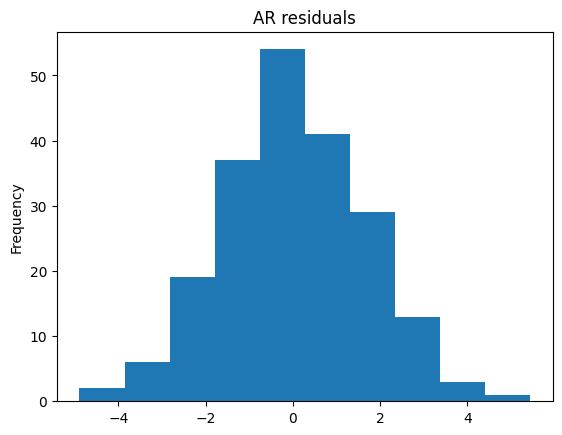

In [123]:
model_fit.resid.plot(kind="hist")
plt.title("AR residuals")
plt.show()

In [124]:
model_fit.resid.describe()

count    205.000000
mean       0.008174
std        1.661427
min       -4.891885
25%       -1.006596
50%       -0.156142
75%        1.098436
max        5.447056
dtype: float64

Finally, we should see no autocorrelation in the residuals:

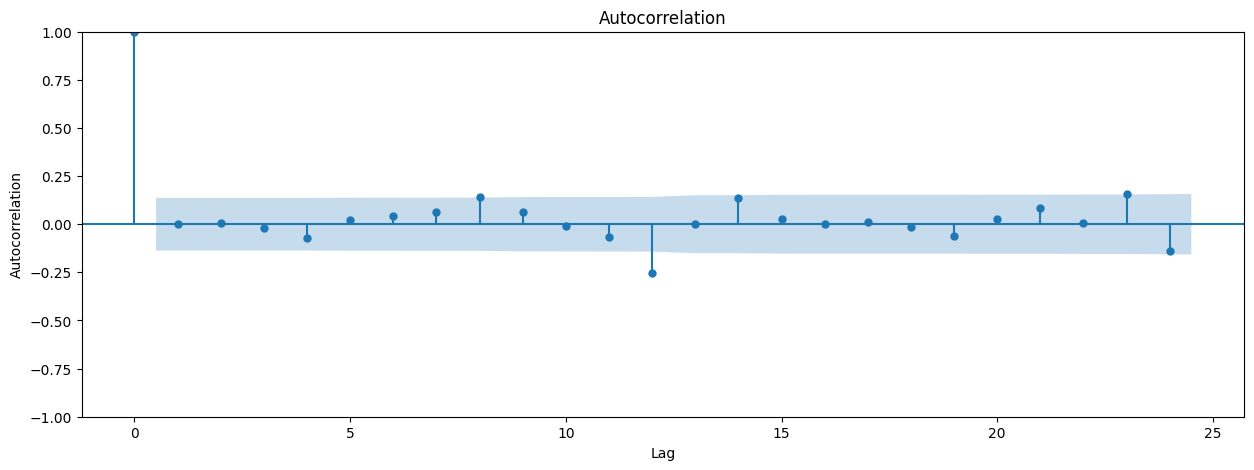

In [125]:
plt.figure(figsize=(15, 5))
plot_acf(model_fit.resid, lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Here too, we see a significant negative autocorrelation at lag 6;  a sign that there was some information in the original data that our model failed to capture.

### Vector Autoregressive Models

The [Vector Autoregressive Model](https://www.statsmodels.org/dev/vector_ar.html) is one of the most commonly used methods for _multivariate time series forecasting_. In a VAR model, we are analysing multiple series simultaneously, modeling each series as a linear combination of the past values of itself and the other series.

As an example, we show the VAR equation for two series, $y_1$ and $y_2$ with lag 1. For calculating $y_1(t)$ (the first series at time $t$), we will use the lagged values of $y_1$ and $y_2$. Similarly, to calculate $y_2(t)$, past values of both $y_1$ and $y_2$ will be used. Below is a simple mathematical way of representing this relation (with $\epsilon_1$ and $\epsilon_2$ denoting the error terms):

$$ y_1 (t) = \beta^1_0 + \beta^1_1 \cdot y_1(t-1) + \beta^1_2 \cdot y_2(t-1) + \epsilon_1 $$
$$ y_2 (t) = \beta^2_0 + \beta^2_1 \cdot y_1(t-1) + \beta^2_2 \cdot y_2(t-1) + \epsilon_2 $$

We will load a built-in data set from the `statsmodels` package to demonstrate this method. To simplify the modeling, we will aggregate the quarterly economic data to yearly measurements. We will use two features: real gross domestic product and personal consumption expenditures.

In [126]:
us_macroecon = sm.datasets.macrodata.load_pandas().data

# set year as index
us_macroecon.index = pd.to_datetime(us_macroecon["year"].astype(int), format="%Y")

# aggregate to yearly data
us_macroecon = us_macroecon[["realgdp", "realcons"]].resample("Y").mean()

In [127]:
us_macroecon.head()

,realgdp,realcons
year,,
1959-12-31,2762.46050,1736.650
1960-12-31,2830.93175,1784.350
1961-12-31,2896.87950,1821.175
1962-12-31,3072.39000,1911.225
1963-12-31,3206.70825,1989.875


In [128]:
fig = px.line(us_macroecon)
fig.update_layout(
    yaxis_title="Bil. of chained 2005 US$", 
    xaxis_title="Year",
    legend_title="", 
    title="Annual GDP and Consumption from 1959 to 2009"
)
fig.show()

We will simply fit the VAR model with lag-1 which will give us the two equations from above.

In [129]:
from statsmodels.tsa.api import VAR

# train-test split
us_macroecon_train = us_macroecon.loc[us_macroecon.index <= "1995", :]
us_macroecon_test = us_macroecon.loc[us_macroecon.index > "1995", :]

# initializing and fitting the model
model = VAR(us_macroecon_train) 
results = model.fit(maxlags=1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 20, Jun, 2023
Time:                     08:37:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    16.3964
Nobs:                     35.0000    HQIC:                   16.2218
Log likelihood:          -375.596    FPE:                1.01256e+07
AIC:                      16.1297    Det(Omega_mle):     8.58997e+06
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             462.572069       105.066190            4.403           0.000
L1.realgdp         -0.159869         0.274193           -0.583           0.560
L1.realcons         1.700512         0.395379            4.301    

Forecasting is done as before:

In [130]:
# forecast - provide the prior values and the number of steps to predict
pred = results.forecast(us_macroecon_train.values, steps=len(us_macroecon_test))

df_forecast = pd.DataFrame(pred, index=us_macroecon_test.index, columns=us_macroecon.columns) 
df_forecast

,realgdp,realcons
year,,
1995-12-31,9109.587630,6088.060898
1996-12-31,9359.052702,6263.162345
1997-12-31,9616.933102,6443.389419
1998-12-31,9882.184343,6628.364807
1999-12-31,10154.331781,6817.940363
2000-12-31,10433.199371,7012.088501
2001-12-31,10718.768349,7210.845627
2002-12-31,11011.103622,7414.282679
2003-12-31,11310.315445,7622.489806


In [131]:
fig = go.Figure()

# GDP data - orig and forecast
fig.add_trace(go.Scatter(x=us_macroecon.index, y=us_macroecon["realgdp"], mode='lines', name="Original GDP"))
fig.add_trace(go.Scatter(x=df_forecast.index, y=df_forecast["realgdp"], mode='lines', name="Forecast GDP", line={'dash': 'dash', 'color': 'blue'}))

# Consumption data - orig and forecast
fig.add_trace(go.Scatter(x=us_macroecon.index, y=us_macroecon["realcons"], name="Original Consumption", line={'color': 'orange'}))
fig.add_trace(go.Scatter(x=df_forecast.index, y=df_forecast["realcons"], mode='lines', name="Forecast Consumption", line={'dash': 'dash', 'color': 'orange'}))

fig.update_layout(
    yaxis_title="Bil. of chained 2005 US$", 
    xaxis_title="Year",
    legend_title="", 
    title="Forecast of the annual GDP and Consumption starting 1995"
)
fig.show()

Selecting the number of lags and VAR parameters is a deep topic, as well as the model evaluation and residual diagnostics; you can read further in the [documentation](https://www.statsmodels.org/dev/vector_ar.html).

### Facebook's Prophet

Facebook has their own time-series forecasting package called Prophet. This package is quite a bit more powerful than ARIMA in `statsmodels`, but we will explore its most basic functionality - further information can be found in the documentation [here](https://facebook.github.io/prophet/).

First, Prophet expects the data to be in a specific format: a dataframe with two columns, `ds` and `y` for the dates and observations.

In [132]:
from prophet import Prophet

prophet_train = air_traffic_monthly.loc[air_traffic_monthly.index <= "1997-01-01", "Revenue Passenger Miles"].reset_index()
prophet_train.rename(columns={"index": "ds", "Revenue Passenger Miles": "y"}, inplace=True)
prophet_train.head()

,ds,y
0,1979-01-01,16.225462
1,1979-02-01,15.032169
2,1979-03-01,18.185524
3,1979-04-01,17.095874
4,1979-05-01,16.066268


Next, we fit the Prophet model with yearly seasonality.

In [133]:
model = Prophet(yearly_seasonality=True)
model.fit(prophet_train)

08:37:52 - cmdstanpy - INFO - Chain [1] start processing
08:37:53 - cmdstanpy - INFO - Chain [1] done processing


To predict in prophet, we actually have to provide an dataframe with a `ds` column. We can create one using `Prophet.make_future_dataframe`

In [134]:
future = model.make_future_dataframe(periods=len(test), freq="MS", include_history=False)
future.head()

,ds
0,1997-02-01
1,1997-03-01
2,1997-04-01
3,1997-05-01
4,1997-06-01


In [135]:
# Notice we need to provide a dataframe for the predict method, it must also contain a `ds` column
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
42,2000-08-01,43.850639,41.867638,46.121622
43,2000-09-01,37.623074,35.399604,39.718172
44,2000-10-01,39.610854,37.498705,41.728276
45,2000-11-01,37.583847,35.544062,39.740812
46,2000-12-01,40.261738,38.116985,42.434264


The forecast actually includes lower and upper confidence limits for our predictions. The Prophet library also includes useful visualization utilities built on top of plotly:

In [136]:
from prophet.plot import plot_plotly

fig = plot_plotly(model, forecast) # returns a plotly Figure object
fig.show()

In [137]:
pd.read_csv('')

FileNotFoundError: [Errno 2] No such file or directory: ''

<div id="container" style="position:relative;">
<div style="position:relative; float:right"><img style="height:25px""width: 50px" src ="https://drive.google.com/uc?export=view&id=14VoXUJftgptWtdNhtNYVm6cjVmEWpki1" />
</div>
</div>